6


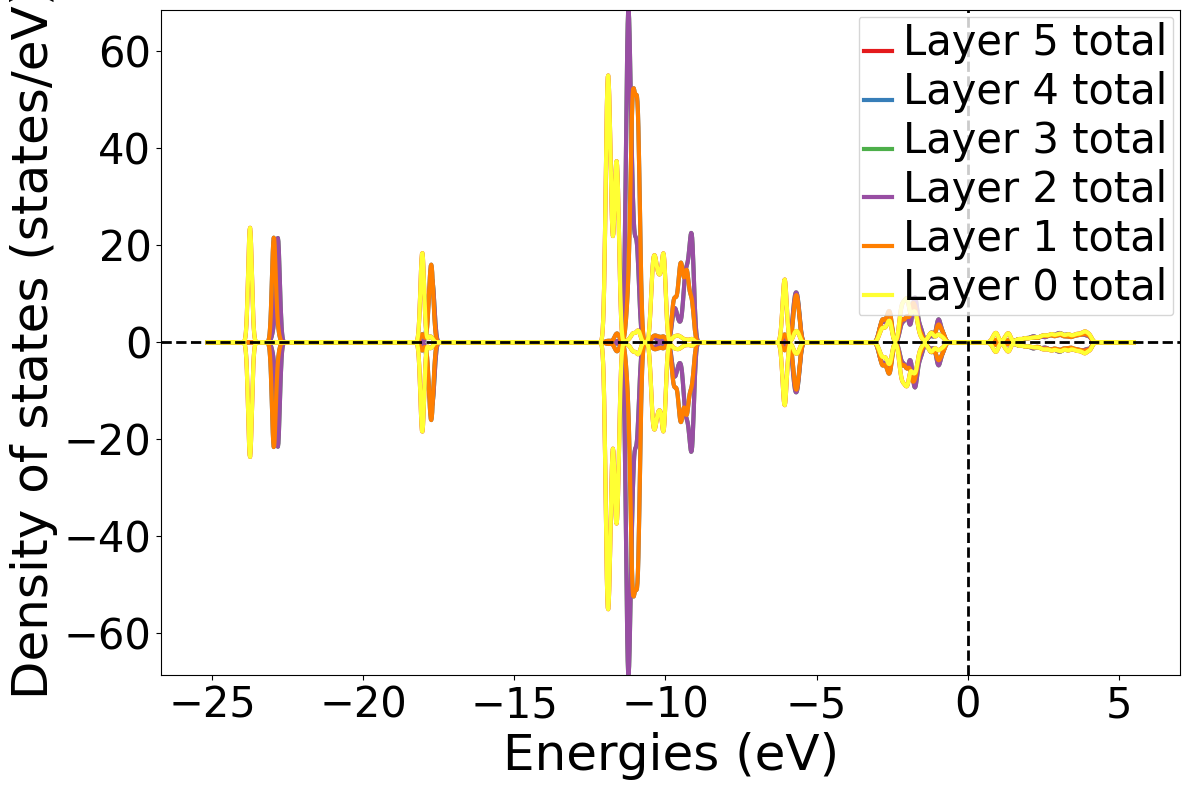

In [1]:
# import matplotlib.pyplot as plt
# import numpy as np
# from pymatgen.io.vasp.outputs import Procar, Vasprun
from pathlib import Path

# # Load PROCAR
path = Path('jfremote_workdirs/example/02/f3/c0/02f3c0b7-4460-44ec-b9ac-cbbb66dd3fb2_1/')
# procar = Procar(path/'PROCAR.gz')

# from pymatgen.electronic_structure.plotter import DosPlotter

# result = Vasprun(path/'vasprun.xml.gz', parse_potcar_file=False)
# complete_dos = result.complete_dos
# pdos_Ga = complete_dos.get_element_spd_dos('Ga')
# pdos_As = complete_dos.get_element_spd_dos('As')
# plotter = DosPlotter()
# plotter.add_dos('Total DOS', result.tdos)
# plotter.save_plot('plot.pdf')

import numpy as np
from pymatgen.electronic_structure.core import Spin, OrbitalType
from pymatgen.electronic_structure.dos import Dos

from pymatgen.io.vasp import Vasprun

vr = Vasprun("/raven/ptmp/twarford/jfremote_workdirs/prod0/07/81/db/0781dbca-43ee-4817-a2f2-8aa0335ff686_1/vasprun.xml.gz", parse_dos=True, parse_potcar_file=False)
cdos = vr.complete_dos   # CompleteDos object (has total DOS + per-site PDOS)
struct = cdos.structure

def layer_groups_by_frac_z(structure, tol=0.02):
    """
    Group site indices into layers by fractional z coordinate.
    tol ~ 0.01–0.03 works for most slabs (tune if needed).
    """
    z = np.array([site.frac_coords[2] % 1.0 for site in structure.sites])
    order = np.argsort(z)
    groups = []
    current = [order[0]]

    for i in order[1:]:
        if abs(z[i] - z[current[-1]]) < tol:
            current.append(i)
        else:
            groups.append(current)
            current = [i]
    groups.append(current)
    print((len(groups)))
    return groups

groups = layer_groups_by_frac_z(struct, tol=0.02)

layer_spd_dos = []  # list of dicts: {"layer": k, "sites": [...], "spd": {OrbitalType: Dos}}
for k, idxs in enumerate(groups):
    # initialize accumulators on the same energy grid
    # take first site as reference for energies/efermi
    ref = cdos.get_site_spd_dos(struct.sites[idxs[0]])
    energies = next(iter(ref.values())).energies
    efermi = cdos.efermi

    acc = {ot: {Spin.up: np.zeros_like(energies), Spin.down: np.zeros_like(energies)} 
           for ot in [OrbitalType.s, OrbitalType.p, OrbitalType.d, OrbitalType.f]}

    for i in idxs:
        spd = cdos.get_site_spd_dos(struct.sites[i])  # dict OrbitalType -> Dos
        for ot, dos_obj in spd.items():
            for spin, dens in dos_obj.densities.items():
                acc[ot][spin] += np.array(dens)

    # build Dos objects per orbital type (only keep orbitals that exist)
    spd_dos = {}
    for ot, dens_by_spin in acc.items():
        # remove empty orbitals (all zeros)
        if all(np.allclose(d, 0) for d in dens_by_spin.values()):
            continue
        # drop missing spin channels cleanly
        dens_by_spin = {s: d for s, d in dens_by_spin.items() if not np.allclose(d, 0)}
        spd_dos[ot] = Dos(efermi, energies, dens_by_spin)

    # Total layer PDOS = sum over all orbital types present
    total_by_spin = {Spin.up: np.zeros_like(energies), Spin.down: np.zeros_like(energies)}
    for dos_obj in spd_dos.values():
        for spin, dens in dos_obj.densities.items():
            total_by_spin[spin] += np.array(dens)
    # Drop empty spin channels (e.g. non-spin-polarized)
    total_by_spin = {s: d for s, d in total_by_spin.items() if not np.allclose(d, 0)}
    layer_total_dos = Dos(efermi, energies, total_by_spin)

    layer_spd_dos.append({"layer": k, "sites": idxs, "spd": spd_dos, "total": layer_total_dos})

# plotter.add_dos('Ga(s)', pdos_Ga[OrbitalType.s])
# plotter.add_dos('Ga(p)', pdos_Ga[OrbitalType.p])
# plotter.add_dos('As(s)', pdos_As[OrbitalType.s])
# plotter.add_dos('As(p)', pdos_As[OrbitalType.p])

# # Extract data
# print(dir(procar))
# bands = procar.data  # shape: (spin, kpoints, bands)
# print({(key, value.shape) for key, value in procar.data.items()})
# kpoints = procar.kpoints

# # Plot (non spin-polarized case)
# for band in range(procar.data):
#     plt.plot(kpoints, bands[0, :, band], color='black', linewidth=0.8)

# plt.xlabel("K-point index")
# plt.ylabel("Energy (eV)")
# plt.title("Band Structure from PROCAR")
# plt.show()
##########
import matplotlib.pyplot as plt
from pymatgen.electronic_structure.plotter import DosPlotter
from pymatgen.electronic_structure.core import OrbitalType, Spin

# Choose which layers to plot (example: top 3 layers)
layers_to_plot = [0, 1, 2, 3, 4, 5]  # change

# Plot TOTAL PDOS for each chosen layer
plotter = DosPlotter(sigma=0.05, zero_at_efermi=True, stack=False)

for entry in layer_spd_dos:
    k = entry["layer"]
    if k not in layers_to_plot:
        continue
    # if k < 3: continue
    plotter.add_dos(f"Layer {k} total", entry["total"])

    # If you want to print the arrays (energies, total DOS), uncomment:
    # dos = entry["total"]
    # print(f"Layer {k} energies shape={dos.energies.shape}")
    # for spin, dens in dos.densities.items():
    #     print(f"  {spin}: dens shape={np.array(dens).shape}, first5={np.array(dens)[:5]}")

plotter.save_plot('fig.pdf')
# fig.gca().axhline(0, linewidth=0.8)  # baseline
# plt.savefig('fig.pdf')



In [8]:
vr = Vasprun("/raven/ptmp/twarford/jfremote_workdirs/prod0/07/81/db/0781dbca-43ee-4817-a2f2-8aa0335ff686_1/vasprun.xml.gz", parse_dos=True, parse_potcar_file=False)
atoms = vr.final_structure.to_ase_atoms()

atoms.arrays['dos_densities'] = np.zeros((len(atoms), 2000))

for i, site in enumerate(vr.final_structure):
    site_dos = vr.complete_dos.get_site_dos(site)
    atoms.arrays['dos_densities'][i] = site_dos.get_densities()

atoms.info['dos_energies'] = site_dos.energies
atoms.info['dos_efermi'] = site_dos.efermi

In [ ]:
def _bin_edges_from_centers(centers):
    midpoints = 0.5 * (centers[:-1] + centers[1:])
    first = centers[0] - (midpoints[0] - centers[0])
    last = centers[-1] + (centers[-1] - midpoints[-1])
    return np.concatenate([[first], midpoints, [last]])

def plot_site_dos_heatmap(
        atoms,
        *,
        zero_at_efermi=True,
        cmap="viridis", 
        ax = None,
        ):
    if "dos_energies" not in atoms.info or "dos_densities" not in atoms.arrays:
        raise ValueError("atoms is missing DOS data")
    
    if ax is None:
        fig, ax = plt.subplots()

    z_positions = atoms.get_positions()[:, 2]
    sort_order = np.argsort(z_positions)

    z_sorted = z_positions[sort_order]
    dos_sorted = atoms.arrays['dos_densities'][sort_order, :]

    z_edges = _bin_edges_from_centers(z_sorted)

    efermi = atoms.info["dos_efermi"]
    energies = atoms.info['dos_energies']
    if zero_at_efermi:
        energies = energies - efermi
    e_edges = _bin_edges_from_centers(energies)

    Z, E = np.meshgrid(z_edges, e_edges)

    e_max = 3
    e_min = -e_max
    vmax = np.max(dos_sorted[:, energies<e_max])

    ax.axhline(
    0,
    color=plt.rcParams['axes.edgecolor'],
    linewidth=plt.rcParams['axes.linewidth'],
    )

    ax.pcolormesh(Z, E, dos_sorted.T, shading='auto', cmap=cmap, norm='log', vmax=vmax,)
    ax.set_ylim(e_min, e_max)
    
    # return ax


(84, 2000) (85,) (2001,)


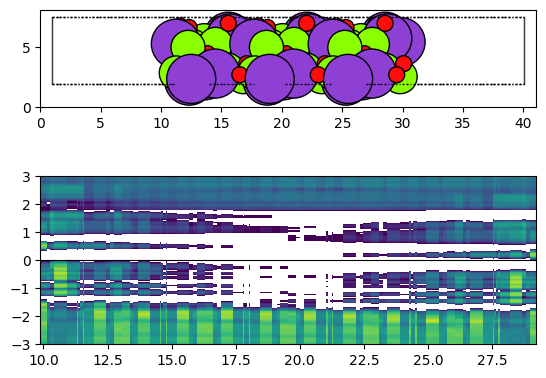

In [29]:
from ase.visualize.plot import plot_atoms
fig, ax = plt.subplots(2, 1)
ax[0] = plot_atoms(atoms, ax[0], rotation=('0x, 90y, 0z'))
ax[1] = plot_site_dos_heatmap(atoms, ax=ax[1])